# Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import beta, binom, lognorm

# Definitions

In [2]:
def multiply_odds(p, odds_multiplier):
    p = np.array(p)
    odds_multiplier = np.array(odds_multiplier)
    assert 0.0 < p.min()
    assert p.max() < 1.0
    assert (odds_multiplier >= 0).all()
    old_odds = p / (1 - p)
    new_odds = old_odds * odds_multiplier
    new_p = new_odds / (1 + new_odds)
    return new_p

In [3]:
def relative_binom_log_likelihood(p: np.ndarray, n: int, x: int):
    # the combinatorial factor is common to all p given fixed (n, x)
    return np.log(p)*x + np.log(1-p)*(n-x)

In [4]:
def joint_likelihood(A_grid, B_grid, nA=0, kA=0, nB=0, kB=0):    
    ll_A = relative_binom_log_likelihood(A_grid, nA, kA)
    ll_B = relative_binom_log_likelihood(B_grid, nB, kB)

    loglikelihood = ll_A + ll_B
    likelihood = np.exp(loglikelihood)
    
    return likelihood / likelihood.sum()

In [5]:
def expected_loss(likelihood_grid, diff_grid):
    weighted_diff_grid = likelihood_grid * diff_grid
    if weighted_diff_grid.sum() > 0:
        weighted_diff_grid *= -1
    return weighted_diff_grid.clip(0).sum()

# Setup

In [7]:
GRID_RESOLUTION = 100
CLTV_A = 22000
CLTV_B = 20000

prior_A = beta(4, 56)
prior_uplift = lognorm(0.4, 0.22)

In [8]:
quantiles = np.linspace(1/(GRID_RESOLUTION*2), 1-1/(GRID_RESOLUTION*2), GRID_RESOLUTION)
A_grid, uplift_grid = np.meshgrid(prior_A.ppf(quantiles), prior_uplift.ppf(quantiles))

In [9]:
B_grid = multiply_odds(A_grid, uplift_grid)

In [10]:
diff_grid = (A_grid * CLTV_A) - (B_grid * CLTV_B)
likelihood_grid = joint_likelihood(A_grid, B_grid) # i.e. the prior
exp_loss = expected_loss(likelihood_grid, diff_grid)
exp_loss

95.74620222023272

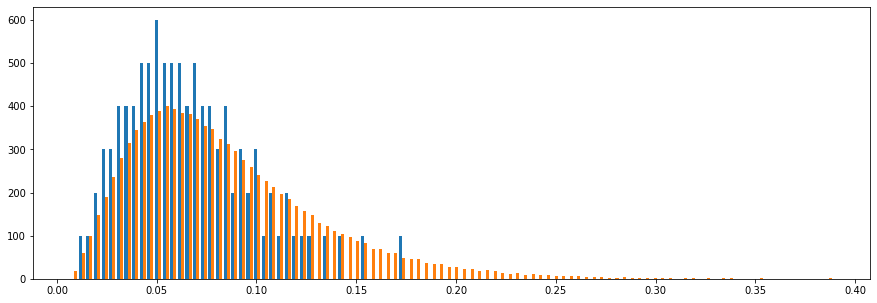

In [11]:
fig, ax = plt.subplots(figsize=(15,5))
ax = plt.hist([A_grid.flatten(), B_grid.flatten()], bins=100);

# Simulation

In [12]:
def run_simulation(A_grid, B_grid, threshold_loss, batch_size,
                   value_A=1, value_B=1, upfront_cost=0, maintenance_cost=0, half_life=None):
    results = []
    initial_choice = 'A' if (A_grid.mean() * value_A) >= (B_grid.mean() * value_B) else 'B'
    diff_grid = (A_grid * value_A) - (B_grid * value_B)
    prior_likelihood = joint_likelihood(A_grid, B_grid)
    initial_exp_loss = expected_loss(prior_likelihood, diff_grid)
    
    for p_A, p_B in zip(A_grid.flatten(), B_grid.flatten()):
        exp_loss = initial_exp_loss
        optimal_choice = 'A' if p_A >= p_B else 'B'
        flips = 0
        kA = 0
        kB = 0
        
        while exp_loss > threshold_loss:
            flips += batch_size
            kA += binom.rvs(batch_size, p_A)
            kB += binom.rvs(batch_size, p_B)
            likelihood_grid = joint_likelihood(A_grid, B_grid, nA=flips, kA=kA, nB=flips, kB=kB)
            exp_loss = expected_loss(likelihood_grid, diff_grid)
        
        if initial_choice == optimal_choice:
            inferior_branch_cost = abs((p_A * value_A) - (p_B * value_B)) * flips
        else:
            inferior_branch_cost = -abs((p_A * value_A) - (p_B * value_B)) * flips
        
        results.append({
            'p_A': p_A,
            'p_B': p_B,
            'kA': kA,
            'kB': kB,
            'inferior_branch_cost': inferior_branch_cost,
            'flips': flips,
            'exp_loss_change': exp_loss - initial_exp_loss,
        })
    
    results = pd.DataFrame(results)
    expected_inferior_branch_cost = results['inferior_branch_cost'].mean()
    expected_duration = results['flips'].mean() * 2
    expected_benefit_per_app = -results['exp_loss_change'].mean()
#     expected_payoff_time = expected_cost / expected_benefit
    
    summary = {
        'expected_inferior_branch_cost': expected_inferior_branch_cost,
        'expected_duration_in_apps': expected_duration,
        'expected_benefit_per_app': expected_benefit_per_app,
#         'expected_payoff_time': expected_payoff_time,
    }
    
    return summary, results

In [17]:
summary, results = run_simulation(A_grid, B_grid, 50, 100, CLTV_A, CLTV_B)

<ipython-input-4-b5fae67046bf>:8: RuntimeWarning: invalid value encountered in true_divide
  return likelihood / likelihood.sum()


In [18]:
summary

{'expected_inferior_branch_cost': 34011.76769895379,
 'expected_duration_in_apps': 584.06,
 'expected_benefit_per_app': 63.64027875385906}

# Hyperparameter tuning

In [41]:
hyper_results = []
for threshold in [80, 70, 60, 50, 40, 30, 20, 10, 5]:
    summary, _ = run_simulation(A_grid, B_grid, threshold, 100, CLTV_A, CLTV_B)
    summary['threshold'] = threshold
    hyper_results.append(summary)
    print(f'threshold {threshold} complete...')
hyper_results = pd.DataFrame(hyper_results)

<ipython-input-4-b5fae67046bf>:8: RuntimeWarning: invalid value encountered in true_divide
  return likelihood / likelihood.sum()


threshold 80 complete...
threshold 70 complete...
threshold 60 complete...
threshold 50 complete...
threshold 40 complete...
threshold 30 complete...
threshold 20 complete...
threshold 10 complete...
threshold 5 complete...


In [42]:
hyper_results

,expected_inferior_branch_cost,expected_duration_in_apps,expected_benefit_per_app,threshold
0,26011.959198,334.82,48.258163,80
1,27990.324604,383.92,52.120279,70
2,29658.696080,471.90,58.032699,60
3,33265.942479,583.38,63.890002,50
4,39374.255268,748.78,69.852875,40
5,47226.931177,974.72,76.208693,30
6,55541.568195,1311.16,82.562260,20
7,77574.689953,1874.58,89.372334,10
8,96489.257606,2263.26,92.639299,5


In [43]:
def profit_optimisation(results_df, upfront_cost=0, maintenance_cost_per_app=0, half_life_in_apps=None):
    results_df = results_df.copy()
    results_df['upfront_cost'] = upfront_cost
    results_df['maintenance_cost'] = maintenance_cost_per_app * results_df['expected_duration_in_apps']
    results_df['total_benefit'] = results_df['expected_benefit_per_app'] * half_life_in_apps/np.log(2)
    results_df['total_cost'] = (results_df['expected_inferior_branch_cost']
                                + results_df['upfront_cost']
                                + results_df['maintenance_cost'])
    results_df['total_profit'] = results_df['total_benefit'] - results_df['total_cost']
    return results_df

In [44]:
profit_optimisation(
    results_df=hyper_results,
    upfront_cost=10000,
    maintenance_cost_per_app=10,
    half_life_in_apps=1000,
)

,expected_inferior_branch_cost,expected_duration_in_apps,expected_benefit_per_app,threshold,upfront_cost,maintenance_cost,total_benefit,total_cost,total_profit
0,26011.959198,334.82,48.258163,80,10000,3348.2,69621.812215,39360.159198,30261.653017
1,27990.324604,383.92,52.120279,70,10000,3839.2,75193.667699,41829.524604,33364.143096
2,29658.696080,471.90,58.032699,60,10000,4719.0,83723.486483,44377.696080,39345.790403
3,33265.942479,583.38,63.890002,50,10000,5833.8,92173.789062,49099.742479,43074.046582
4,39374.255268,748.78,69.852875,40,10000,7487.8,100776.396617,56862.055268,43914.341349
5,47226.931177,974.72,76.208693,30,10000,9747.2,109945.903830,66974.131177,42971.772652
6,55541.568195,1311.16,82.562260,20,10000,13111.6,119112.163181,78653.168195,40458.994987
7,77574.689953,1874.58,89.372334,10,10000,18745.8,128937.022475,106320.489953,22616.532522
8,96489.257606,2263.26,92.639299,5,10000,22632.6,133650.257930,129121.857606,4528.400323


# Notes

We probably don't need to replicate the test for each successive threshold - we could just run once for the harshest threshold and then keep track of when each of the other "easier" levels were reached. We could then make up for (and improve on) the extra smoothing benefit of large N by increasing the resolution.

# Archive

In [224]:
def binom_log_likelihood(p, n, x):
    log_comb = np.log(comb(n, x))
    assert not np.isinf(log_comb)
    return log_comb + np.log(p)*x + np.log(1-p)*(n-x)

In [289]:
def safe_binom_log_likelihood(p, n, x):
    log_comb = gammaln(n+1) - gammaln(x+1) - gammaln(n-x+1)
    return log_comb + np.log(p)*x + np.log(1-p)*(n-x)

In [222]:
def plot_dist(dist, resolution=100, x=None, figsize=(15,5), ax=None, style='r-', label=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    if x is None:
        x = np.linspace(dist.ppf(1/(resolution*2)), dist.ppf(1 - 1/(resolution*2)), resolution)
    ax.plot(x, dist.pdf(x), style, lw=4, alpha=0.6, label=label)
    plt.legend()
    return ax